# Assignment: Transient Groundwater Flow Course IHE feb 2024

By prof. dr.ir. TN Olsthoorn

The [course material](https://github.com/Olsthoorn) can be found on Github

And as an [online course](https://readthedocs.org/profiles/Olsthoorn/) on readthedocs.org

The up-to-date s[yllabus as a pdf](https://github.com/Olsthoorn/TransientGroundwaterFlow) an also be found on Github.

On the same site you can find the PowerPoint presentations that are used in class and numerous exercises done in jupyter notebooks as well as the notebooks that generated the animations and all the pictures in the syllabus.

Old exams with and without answers and the asignments given over the years from 2006 can be find at the end of the [online course](https://readthedocs.org/profiles/Olsthoorn/) on Readthedocs. 

Extra material will be given to the students in class or save on github.

This year there will not be a written exam; only an assigment. This gives more oppertunities to learn and demonstrate the use of the transient analytic solutions presented in the course in a more data science scope. Nowadays, the anlytic formulas are at least as important as in the past before wide-spread computing being available, as more than ever we need them als tools to verify the many numeric models around, which just produce numbers, no insight. There outcomes require verification. Also before starting a new large groundwater model, most and valuable analysis can be and should be done ahead of it, to analyse the problem at hand and it's likely behavior to help us build better models by knowing what matters and by understanding and interpreting its outcomes. Moreover anaytic solutions allow us to generalize other outcomes and allow us to predict which are crucial paramters how variaion of the parameters will affect the outcomes. In short analytic solutions provide insight and guide is all the time when dealing with groundwater problems in a quantitive and qualitative way.

With more data science focus, we talk about analyzing field data using our analytic soltion, to find out how these field data can be interpreted and what the underlying parameters and relations are that cause the observed behavior. This way the filed data, mostly in terms of continuous or high-frequency registrations of water pressures, flows, recharge, evoration, pumping, water level fluctuations and so on, have to be analyzed. Signals have to be separated from noise, further, signals caused by different phenomena, all affecting the registered water pressure, have to be separated to determine what part of the observed behevior is due to what phenomenon, i.e. due to rain, pumping, water fluctuation and so on. These phenomena and their effects are all dynamic, and, therefore, we will mostly deal with large time series, which is what is called data-science.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc, k0 as K0, exp1 as Wt
from scipy.integrate import quad
from scipy.signal import lfilter
import pandas as pd
from PIL import Image
from itertools import cycle


In [2]:
def newfig(title='title', xlabel='xlabel', ylabel='ylabel', xscale='linear', yscale='linear',
           xlim=None, ylim=None, figsize=(6, 6)):
    """Return ax of new figure."""
    fig, ax = plt.subplots(1, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if xscale: ax.set_xscale(xscale)
    if yscale: ax.set_yscale(yscale)
    if figsize: fig.set_size_inches = figsize
    ax.grid(True)
    return ax

In [3]:
def Wh(u, rho=0):
    """Return Hantush well function values.

    This function uses numerical integration with scipy.ingegratge.quad
    and vectorizes the obtainded functions to use it with arrays of input.
    
    The resulting function is extremely fast and accurate!

    Parameters
    ----------
    u : float | nd.array of floats
        u = r^2 / (4 kD t)
    rho: float | None
        r / lambda with lambda = sqrt(kD c)

    Some exmple uses
    ----------------
    
    >>>Wh(0.004, 0.03)
    4.894104204671381
    
    >>>Wh(0.08, 0.06)
    2.0184074022446836

    >>>Wh(0.08) # Use Wh without rho, to get the Theis well function value
    2.0269410025857217

    >>>Wt(0.08) # Show that the Theis well funciton Wt(u) = Wh(u)
    2.0269410025857417
    
    """
    def kernel(y, rho):
        """Return the function to be integrated."""
        return np.exp(-y - (rho / 2) ** 2 / y) / y
    def w(u, rho): # Integrate the argument
        return quad(kernel, u, np.inf, args=(rho,))[0]
    wh = np.frompyfunc(w, 2, 1) # Vectorize function w(u, rho) so we can use arrays as input.
    
    return wh(u, rho)



# 1. Show the combined impact of a number of well fields in Lybia

A water company extracts water from a dune are along the North sea and uses rows of wells to capture the water. The coordinates in Latitude (North), Longitude (East) are given [here](./data/PumpingSitesLybia.csv).

![Image projected on Google Earth](./images/LybiaPumpingSites.png)


## First get the coordinates:

The pumping sites are read from the file './data/PumpingSitesLybia.csv' into a pandas DataFrame.
These coordinates are in East and North degrees (WGS84, Google world coordinates). We first convert thme in to km east of the zero meridian and north of the equator, using a simple function that assumes the world is a sphere.

In [4]:
psites = pd.read_csv(os.path.join('./data', 'PumpingSitesLybia.csv'), index_col=0)

def wgs2km(phi, lam):
    """Return approximate x [km], y [km] from latitude [deg], longitude [deg].

    This assumes the world is a sphere.

    Parameters
    ----------
    phi: float
        Degrees north with respect to the equaator
    lam: float
        Degrees east with respect to the zero meridian.

    Returns
    -------
    Coordinates in km
    """
    R = 6378.0 # km
    phi, lam = phi * np.pi / 180., lam * np.pi / 180.
    y = R * phi
    x = R * np.cos(phi) * lam
    return np.round(x, 1), np.round(y, 1)

xkm, ykm = wgs2km(psites['N_GWS84'].values, psites['E_GWS84'].values)

psites['xkm'] = xkm
psites['ykm'] = ykm

xBorderEgypt, yMediterranean = wgs2km(31, 25)
print('The x-coordinate of the Egyption border (Lon = 25deg) = {} km'.format(xBorderEgypt))
print('The y-coordinage of the Mediterranean   (Lat = 31deg) = {} km'.format(yMediterranean))

# Egyptian border point:
xB, yB = wgs2km(25, 25) 
print("Egyptian border point = (x={}, y={})".format(xB, yB))
print(psites)

# The coordinates of the Google image are approximately
# lat 9.5 to 30.0 deg and lon 9.5 to 30 deg
loweleft_upperright_km = wgs2km(np.array([19.8, 33.5]), np.array([9.5, 30.0]))

print(loweleft_upperright_km)

The x-coordinate of the Egyption border (Lon = 25deg) = 2385.4 km
The y-coordinage of the Mediterranean   (Lat = 31deg) = 3450.8 km
Egyptian border point = (x=2522.2, y=2782.9)
                    E_GWS84    N_GWS84     xkm     ykm
Name                                                  
Ghadarnes         10.870178  29.330456  1054.9  3265.0
Jabal_Hasouna_NE  13.026915  27.042600  1291.6  3010.3
Jabal_Hasouna_E   14.782520  26.308762  1475.1  2928.6
Tazerbo_W         20.547701  24.853721  2075.5  2766.6
Tazerbo_E         22.248636  23.778889  2266.4  2647.0
Sarir             20.428217  27.471861  2017.6  3058.1
Jahgboub          23.895349  29.554800  2313.9  3290.0
(array([ 995. , 2784.8]), array([2204.1, 3729.1]))


If you know the extent of your image, you can put this image on a figure with the right coordiates and plot your drawdown contours directly on it.

Here is the image put in a pictures with the coordinates in km (y=from equator, x=from zero meridian)

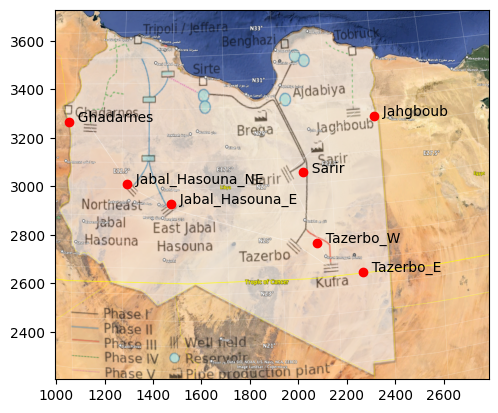

In [5]:
extent = list(loweleft_upperright_km[0]) + list(loweleft_upperright_km[1])

Lybia_egypt = Image.open('./images/LybiaPumpingSites.png')
plt.imshow(Lybia_egypt, extent=extent)

for k in psites.index:
    x, y = psites.loc[k, ['xkm', 'ykm']]
    plt.plot(x, y, 'ro')
    plt.text(x, y, '  ' + k)

# Further information:

#### The discharge per pumping site

Now take the pumping capacity given that the transport pipes have $D = 4$ m diameter serving 2 pumping sites. Just assume a flow velocity of $v = 0.5$ m/s on average. The the discharge per pumping sites is estimated to

$$ Q \approx \frac{1}{2} \pi \, D^2 \, v $$

Take this as discharge per pump site.

The extraction would be estimated to be aoubt $Q = 0.5 \pi R_{pipe)^2 v$ where the 0.5 comes from the map that shows that two pumping stations are feed into the major 4 m diameter pipelines. This is further converted to m3/d.
And so Q = 271433 m3/d,  which, of course we round to a reasonalble accuracy of 270,000 m3/d or a 100 million m3/year per pumping station.

In [6]:
Qps = 0.5 * np.pi * 2 ** 2 * 0.5 * 86400 # 0.5 pi Rp ** 2 * v  * seconds_per_day [m/s] = Qps = 270000 # m3/d
Qps = round(Qps / 1e4) * 1e4
print('Qps = {:.0f} m3/d (= daily extarction by each pumping station'.format(Qps))

Qps = 270000 m3/d (= daily extarction by each pumping station


#### Aquifer properties

Further assume the transmissity of the Nubian Sandstone is $kD = 5000$ m2/d and $S = 0.0005$.

Finally take the Mediterranean sea as a fixed-head boundary, giving rise to mirror wells.

In [7]:
kD = 5000 # [m2/d] transmissivity 
S = 0.0005 # [-] elastic stoage coefficient

### The questions

1. Start with computing the radius of influence (in km) to have an impression of the extent of the drawdown
1. Compute the drawdown today (assuming that the system has been working since 1984)
1. Contour the drawdown for 2024 directly on the picture.
1. Compute the drawdown over time at the Egypian border at (x=2522.2, y=2782.9)
1. Compute the drawdown over time (1984-2024) at 1000 m from the point Tazerbo assuming this is the approximate radius of the pumping well ensemble.
1. Have a look on Google Earth, zoom in at point (lat=24.2 deg, lon=23.4 deg) to see the well site of Kufra

Remark: The real transmissivity may be less and the real storage coefficient larger than used in this exercise.

### Question 1, radius of influence

In [8]:
times = np.logspace(0, 2, 21) * 365  # From 0 to 100 days in steps of one year 
R_infl = np.sqrt(2.25 * kD * times / S) # km

print('{:5s} {}'.format('time', 'R_inflence'))
print('{:5s}    {:5s}'.format('years', 'km'))
for t, R in zip(times, R_infl):
    print('{:5.1f}  {:4.0f}'.format(t / 365, R / 1000))
    


time  R_inflence
years    km   
  1.0    91
  1.3   102
  1.6   114
  2.0   128
  2.5   144
  3.2   161
  4.0   181
  5.0   203
  6.3   228
  7.9   255
 10.0   287
 12.6   322
 15.8   361
 20.0   405
 25.1   454
 31.6   510
 39.8   572
 50.1   642
 63.1   720
 79.4   808
100.0   906


### Question 2: Drawdown today due to assumed pumping since 1984

This is done by superposition of the dradown by all pumping station

In [9]:
psites['Q'] = 270000 # add an extraction column to the DataFrame (for convenience)
print(psites)

                    E_GWS84    N_GWS84     xkm     ykm       Q
Name                                                          
Ghadarnes         10.870178  29.330456  1054.9  3265.0  270000
Jabal_Hasouna_NE  13.026915  27.042600  1291.6  3010.3  270000
Jabal_Hasouna_E   14.782520  26.308762  1475.1  2928.6  270000
Tazerbo_W         20.547701  24.853721  2075.5  2766.6  270000
Tazerbo_E         22.248636  23.778889  2266.4  2647.0  270000
Sarir             20.428217  27.471861  2017.6  3058.1  270000
Jahgboub          23.895349  29.554800  2313.9  3290.0  270000


In [10]:
kD = 5000. # m2/d
Q = 270000. # m3/d

Compute the drawdown at an arbitrary location xp, yp ove time.

Let the point of interest be an arbitrary point x, y at a disance r from the station at x0, y0.

We compute the darwdown for a series of times between 1 and 100 years. The point at t = 40 years answers the question.

The computations are done in dimension m and d. However the coordinates are in km. The only thing to do then is to multiply the radius r by 1000 to convert it form km to m.

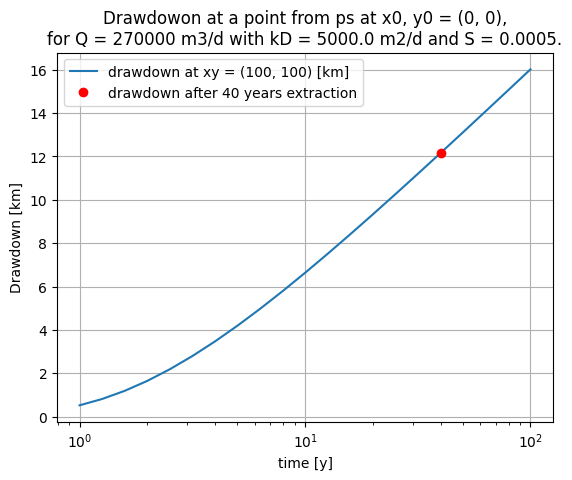

In [11]:
aYear = 365 # [d/y]
mperkm = 1000 # meters per km
x, y = 100, 100 # in km
x0, y0 = 0, 0,  # in km
r = np.sqrt((x - x0) ** 2 + (y - y0) ** 2) * mperkm # convert ot m
times = np.logspace(0, 2, 21) * aYear
u = r ** 2 * S / (4 * kD * times)
s = Q / (4 * np.pi * kD) * Wt(u)

plt.title('Drawdowon at a point from ps at x0, y0 = ({:.0f}, {:.0f}),\nfor Q = {:.0f} m3/d with kD = {:.1f} m2/d and S = {}.'.format(x0, y0, Q, kD, S))
plt.ylabel('Drawdown [km]')
plt.xlabel('time [y]')
plt.grid()
plt.xscale('log')
plt.plot(times / aYear, s, label='drawdown at xy = ({:.0f}, {:.0f}) [km]'.format(x, y)) # See how I change the scale of the presentatio to have it in years.
plt.plot(40, Q  / (4 * np.pi * kD) * Wt(r ** 2 * S / (4 * kD * 40 * aYear)), 'ro', label="drawdown after 40 years extraction")
plt.legend()

### Question 3: Contour drawdown after 40 years of extraction

In [12]:
# Make grid, so the point x, y are now going to be grid points X, Y
# From the map we see that a suitable grid would be in km
xlim = (1000, 2800)
ylim = (2200, 3800)
x = np.linspace(xlim[0], xlim[1], int((xlim[1] - xlim[0]) / 20) + 1) # A 2 km interval (2800 - 1000) / 90 = 20 km
y = np.linspace(ylim[0], ylim[1], int((ylim[1] - ylim[0]) / 20) + 1)
print(x)
print(y)
X, Y = np.meshgrid(x, y) # Generate the coordinates for all the points of the grid defined by x and y (use capitals X, Y for the grid)
print(X.shape)
print(Y.shape)

[1000. 1020. 1040. 1060. 1080. 1100. 1120. 1140. 1160. 1180. 1200. 1220.
 1240. 1260. 1280. 1300. 1320. 1340. 1360. 1380. 1400. 1420. 1440. 1460.
 1480. 1500. 1520. 1540. 1560. 1580. 1600. 1620. 1640. 1660. 1680. 1700.
 1720. 1740. 1760. 1780. 1800. 1820. 1840. 1860. 1880. 1900. 1920. 1940.
 1960. 1980. 2000. 2020. 2040. 2060. 2080. 2100. 2120. 2140. 2160. 2180.
 2200. 2220. 2240. 2260. 2280. 2300. 2320. 2340. 2360. 2380. 2400. 2420.
 2440. 2460. 2480. 2500. 2520. 2540. 2560. 2580. 2600. 2620. 2640. 2660.
 2680. 2700. 2720. 2740. 2760. 2780. 2800.]
[2200. 2220. 2240. 2260. 2280. 2300. 2320. 2340. 2360. 2380. 2400. 2420.
 2440. 2460. 2480. 2500. 2520. 2540. 2560. 2580. 2600. 2620. 2640. 2660.
 2680. 2700. 2720. 2740. 2760. 2780. 2800. 2820. 2840. 2860. 2880. 2900.
 2920. 2940. 2960. 2980. 3000. 3020. 3040. 3060. 3080. 3100. 3120. 3140.
 3160. 3180. 3200. 3220. 3240. 3260. 3280. 3300. 3320. 3340. 3360. 3380.
 3400. 3420. 3440. 3460. 3480. 3500. 3520. 3540. 3560. 3580. 3600. 3620.
 3640. 

In [13]:
psites.loc['Ghadarnes']

E_GWS84        10.870178
N_GWS84        29.330456
xkm          1054.900000
ykm          3265.000000
Q          270000.000000
Name: Ghadarnes, dtype: float64

In [14]:
for name in psites.index:
    x, y, Q = psites.loc[name][['xkm', 'ykm', 'Q']]
    print(x, y, Q, name)


1054.9 3265.0 270000.0 Ghadarnes
1291.6 3010.3 270000.0 Jabal_Hasouna_NE
1475.1 2928.6 270000.0 Jabal_Hasouna_E
2075.5 2766.6 270000.0 Tazerbo_W
2266.4 2647.0 270000.0 Tazerbo_E
2017.6 3058.1 270000.0 Sarir
2313.9 3290.0 270000.0 Jahgboub


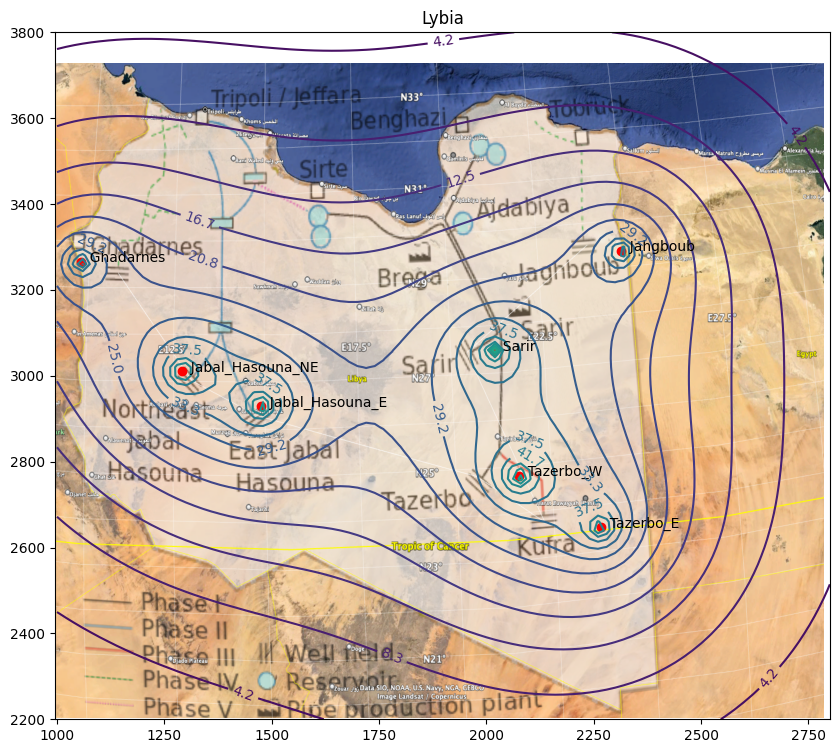

In [15]:
mperkm = 1000 # meters per km for conversion
s = np.zeros_like(X) # initial drawdown

time = 40 * aYear
plt.title("Lybia")

extent = list(loweleft_upperright_km[0]) + list(loweleft_upperright_km[1])

Lybia_egypt = Image.open('./images/LybiaPumpingSites.png')
plt.imshow(Lybia_egypt, extent=extent)

plt.gcf().set_size_inches(10, 10)

for name in psites.index:
    x0, y0, Q = psites.loc[name][['xkm', 'ykm', 'Q']]
    r = np.sqrt((X - x0) ** 2 + (Y - y0) ** 2) * mperkm 
    u = r ** 2 * S / (4 * kD * time)
    s += Q  / (4 * np.pi * kD) * Wt(u)
    plt.plot(x0, y0, 'ro')
    plt.text(x0, y0, '  ' + name, ha='left')
    
cs = plt.contour(X, Y, s, levels=np.linspace(0, 100, 25))
plt.clabel(cs)
plt.show()

Of course, we could take into account the Mediteranean sea as a head boundary condition, by using mirror wells. 

### Question 3, the drawodown at the Egyptian border follows from the contoured drawdowns above.

This drawwdown already follows from the contours of the previous question.

### Question 4. What is the drawdown after 40 years pumping at 1000 m from pumping site Tazero?

We can compute this drawdown while ignoring that by all other pumpoing sites, jsut to see how deep the dawdown is expected to be at leas at the bounary of the pumping area of this station. The size of the area is estimated at 1000 m.

The extraction will be Q = 270000 m3/d.


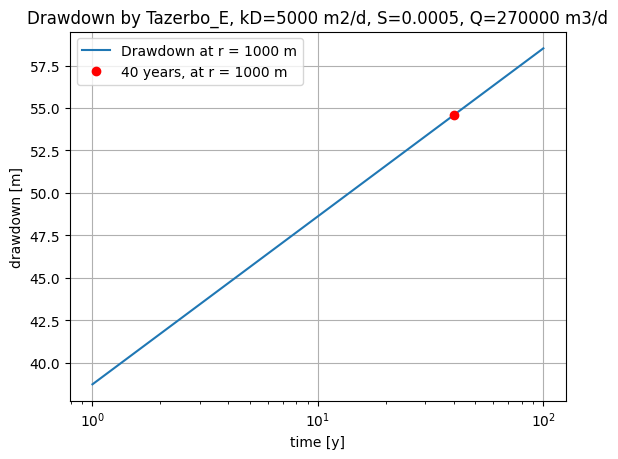

In [16]:
time = np.logspace(0, 2, 21) * aYear
kD =5000 # m2/d
S = 0.0005 # [-]
r = 1000 # m
name = 'Tazerbo_E'
Q = psites.loc[name, 'Q']
plt.title("Drawdown by {}, kD={:.0f} m2/d, S={:.3g}, Q={:.0f} m3/d".format(name, kD, S, Q))
plt.xlabel('time [y]')
plt.ylabel('drawdown [m]')
plt.grid()
plt.xscale('log')
u = r ** 2 * S  / (4 * kD * time)
plt.plot(time / aYear, Q / (4 * np.pi * kD) * Wt(u), label='Drawdown at r = {:.0f} m'.format(r))
plt.plot(40, Q  / (4 * np.pi * kD) * Wt(r ** 2 * S / (4 * kD * 40 * aYear)), 'ro', label='40 years, at r = {:.0f} m'.format(r))
plt.legend()
plt.show()
         

# 2. Impact of long-level rise of Lake Nasser (Egypt) on adjacent groundwater

Lake Nasser (Egypt) was formed after construction of the Assuan Dam in the early 20th century. The high dam was ready in 1965, after which Lake Nasser started to rise and extend until what it is today. The rise of the Lake between 1965 and 2005 is shown in the graph. The data with the water level over time is also given.
The rise of the lake level causes infiltration of Lake / Nile water into the aquifers adjacent to the lake. The groundwater in these aquifer will continue to rise over centuries while these aquiers slowly fill up. Full equilibirium will likely never be reached because there are not fixed head boundaries that could cause equilibrium to establish. But then the question raises, how far and to what exent does the groundwater rise? Will low areas get wet and form salt lakes? Can the new groundwater be used for agriculture and when and to what exent, and so on. To answer such questions you are asked to quantify the gradual rise of the grounwater in points at different distances from the lake lying in a cross section.

But to be able to quantify the effect and predict the future of it, you well need to calibrate you parameters kD and S. You can do that by matching your model with observations. Observed heads are available at 6 piezometers situated at different distances from the lake. For each piezometer the head is available for a number of times. You can do the calibration by hand, by changing the kD and the S and run the simulation again until your model matches the data. It is believed from the data obtained from drilling of the piezometers when they were intstalled, that the transmissivity will be in the order of 600 m2/d and the storage coefficient in the order of 5%. So these values are a good starting point for your calibration.

## Questions

#### 1. Show the lake level and the measured heads

Show the lake level and the measured heads as a funciton of time in graphs in a single plot. For this you need to read the data into your notebook and plot them.

#### 2. Construct and test your model

Your model will be the analytic solution that gives the change of head $s(x, t)$ over time caused by a sudden change of head $A$ [m] at $x=0$. That is:
$$ S = A \, erfc(u),\,\,\,\,\,with\,\,\,\,\,u=\sqrt{\frac{x^2 S_y}{4 kD t}} $$

Use `convolution` (i.e. moving average weighted by the response) to simulate the head $h$ at the locations $x$ for which you were given the piezometer data. Show the results in the same plot together with the lake level and the measurements.

Note that the `Step Response` $SR$ is the effect of a sudden change at $x=0$ by $A = 1$ m!
Further realize that the change of head from one day to the next is a sudden change on that day.

The model is imply the convolution (moving average) that ais done by the function `scipy.signal.lfilter(SR, 1, np.diff(hLake))` where `np.diff(hLake)` is an array of the day-to-day changes of the lake level. `np.diff` just computes `hlake[i+1] - hlake[i]` or compactor without neding a loop, `hlake[1:] - hlake[:-1]`.

#### 3. Show that your model works.

In [17]:
dirname = os.path.join('./data', 'lake_nasser')
assert os.path.isdir(dirname), "Can't find directory {} !".format(dirname)
print(dirname)

./data/lake_nasser


In [18]:
os.listdir(dirname)

['headAt302.csv',
 'headAt3147.csv',
 'nasser_lake.csv',
 'headAt10898.csv',
 'headAt960.csv',
 'headAt27504.csv']

In [19]:
# Convert the dates in the index (which are strings to np.datetime64 objects.
# This can be done most easily with a list comprehension.
# Look up in Google what that is, because comprehensions are extremely powerful
lake = pd.read_csv(os.path.join(dirname, 'nasser_lake.csv'), index_col=0)
lake.index = [np.datetime64(f) for f in lake.index]
lake.index[:10]

DatetimeIndex(['1965-03-12', '1965-03-13', '1965-03-14', '1965-03-15',
               '1965-03-16', '1965-03-17', '1965-03-18', '1965-03-19',
               '1965-03-20', '1965-03-21'],
              dtype='datetime64[ns]', freq=None)

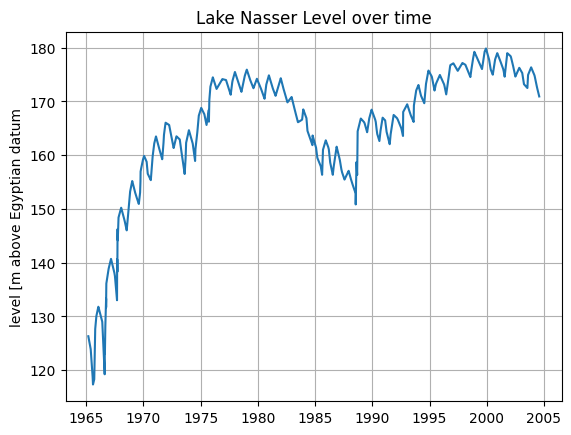

In [20]:
plt.title("Lake Nasser Level over time")
plt.ylabel("level [m above Egyptian datum")
plt.grid()
plt.plot(lake)
# fig = plt.gcf() # gcf() "get current figure" this gives the current figure.
# fig.set_size_inches(12, 6) # the figure has a function to set the size of the figure

### Get the piezometer data (the csvfiles)

Each one will be read into a pandas.DataFrame, then converted to a pandas.Series, by selecting only the column ['h']. And immediately each of  the piezometer data area stored in a Dictioinary named "piezoms" with the distance to the lake as their key. Later on we can select piezoms like so (the one at 960  from the lake for insstance as `piezoms[906]`, which is convenient.

In [21]:
csvfiles = [f for f in os.listdir(dirname) if f.endswith('.csv') if f.startswith('headAt')]

In [22]:
piezoms = {}
for fname in csvfiles:
    d = int(fname[6:-4])
    piezoms[d] = pd.read_csv(os.path.join(dirname, fname), index_col=0, parse_dates=True)

# Sort such that the keys are increasing (keys are distance to the lake)
piezoms = dict(sorted(piezoms.items())) # show what we now have in the dictioary piezoms
print(piezoms.keys())

dict_keys([302, 960, 3147, 10898, 27504])


Add the piezometer data to the graph

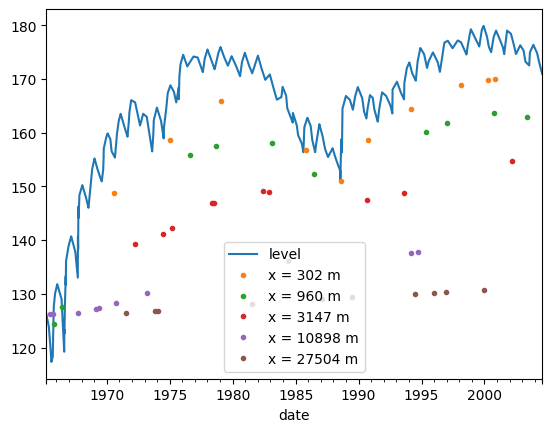

In [23]:
lake['level'].plot()
for key in piezoms:
    piezoms[key]['h'].plot(ls='none', marker='.', label='x = {} m'.format(key))
plt.legend()
    

### Simulate the heads

To be able to simulate we need to convert the datatime objects in the inddex of the lake and each of the piezometesto plot the graph. They are now np.datetime64 objects. But for simulation we need the time as floating point numbers. We can do this by subtracting the datetime of the first measument from the index. We then have np.timedelta64 objects, denoting time differences0. By defining these by the length of one day, i.e. np.timedelta64(1,  'D') we get the times in floating point numbers with the accuracy of one day. By deviding by np.timedelta64(1, 'm') we get the in minute accuracy, by diviging by np.timedelta64(1, 's') in second accuracy. For now day accuracy is just fine. I show this for the index of the lake:

In [24]:
tds = lake.index - lake.index[0] # Gives an array of np.timedelta64 objects
tds

TimedeltaIndex([    '0 days',     '1 days',     '2 days',     '3 days',
                    '4 days',     '5 days',     '6 days',     '7 days',
                    '8 days',     '9 days',
                ...
                '14379 days', '14380 days', '14381 days', '14382 days',
                '14383 days', '14384 days', '14385 days', '14386 days',
                '14387 days', '14388 days'],
               dtype='timedelta64[ns]', length=14389, freq=None)

In [25]:
# Divide this tds by the timedelta representing one day, i.e. np.timdelta64(1, 'D') and we have our times in just floating point values
# That we can use in our model.
tds / np.timedelta64(1, 'D')

Index([    0.0,     1.0,     2.0,     3.0,     4.0,     5.0,     6.0,     7.0,
           8.0,     9.0,
       ...
       14379.0, 14380.0, 14381.0, 14382.0, 14383.0, 14384.0, 14385.0, 14386.0,
       14387.0, 14388.0],
      dtype='float64', length=14389)

We can simpply add a column to all our data that holds these times. The times are then in days with respect to the first index value of the lake data: lake.index[0]

In [26]:
startDate = lake.index[0]
lake['t'] = (lake.index - startDate ) / np.timedelta64(1, 'D')

for key in piezoms:
    piezoms[key]['t'] = (piezoms[key].index - startDate) / np.timedelta64(1, 'D')

In [27]:
k = [k for k in piezoms][0]
print('piezoms[{}]'.format(k))
piezoms[k]

piezoms[302]


,x,h,t
date,,,
1970-08-11,302.0,148.794612,1978.0
1975-01-13,302.0,158.665144,3594.0
1979-01-19,302.0,165.834332,5061.0
1985-11-01,302.0,156.780785,7539.0
1988-07-30,302.0,151.070967,8541.0
1990-09-20,302.0,158.693888,9323.0
1994-03-01,302.0,164.340664,10581.0
1998-02-12,302.0,168.791259,12025.0
2000-04-13,302.0,169.736210,12816.0


Now use column['t'] in the plot instead of datenum, the xaxis is then in days since the first measurment

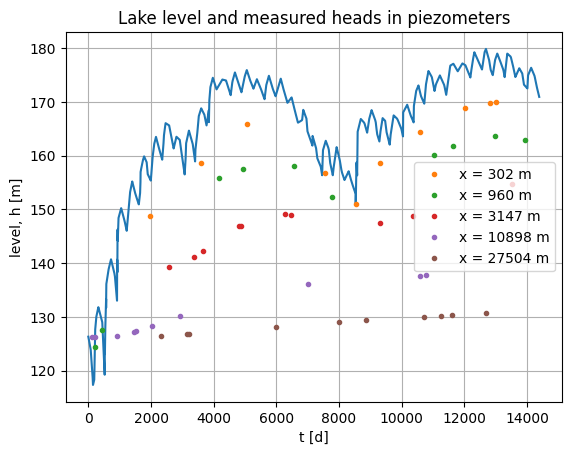

In [28]:
plt.title("Lake level and measured heads in piezometers")
plt.xlabel('t [d]')
plt.ylabel('level, h [m]')
plt.plot(lake['t'], lake['level'])
plt.grid()
for key in piezoms:
    plt.plot(piezoms[key]['t'], piezoms[key]['h'], ls='none', marker='.', label='x = {} m'.format(key))
plt.legend()

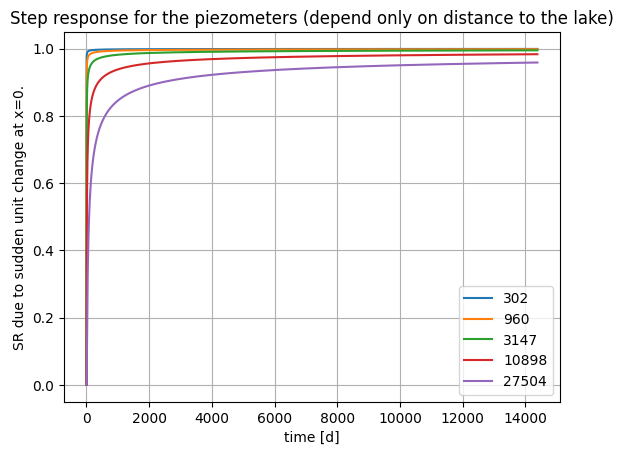

In [29]:
plt.title('Step response for the piezometers (depend only on distance to the lake)')
plt.xlabel('time [d]')
plt.ylabel('SR due to sudden unit change at x=0.')
plt.grid()
t = lake['t']
for key in piezoms:
    x = key
    u = x * np.sqrt(S  / (4 * kD * lake['t']))
    SR = 1.0 * erfc(u)
    plt.plot(lake['t'], SR, '-', label=key)
plt.legend()
plt.show()


We can use thse step response simmediately in simulation, this is done by the function `lfilter` from `scipy.signal`

In [30]:
print('Star level of the lake {:.1f} m.'.format(lake.iloc[0]['level']))

Star level of the lake 126.3 m.


Hellow world


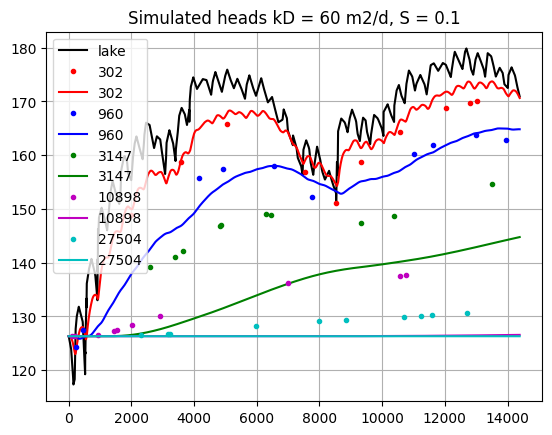

In [31]:
kD_over_S = 600
S = 0.1
kD = kD_over_S * S

plt.title("Simulated heads kD = {:.0f} m2/d, S = {:.3g}".format(kD, S))
plt.plot(lake['t'], lake['level'], 'k', ls='-', label='lake')
plt.grid()

clrs = cycle('rbgmc')

print('Hellow world')
for key in piezoms:
    clr = next(clrs)
    tau = lake['t']
    x = key 
    u = x * np.sqrt(S / (4 * kD * tau))
    SR = 1.0 * erfc(u)
    plt.plot(piezoms[key]['t'], piezoms[key]['h'], color=clr, ls='none', marker='.', label=key)
    s = lfilter(SR, 1.0, np.diff(lake['level'])) + lake.iloc[0]['level']
    plt.plot(lake['t'][1:], s, color=clr, ls='-', label=key)
plt.legend()
plt.show()

To calibrate the model, we must first have a model. The model in this case will be the simulation of the head by the convolution using the solution of the sudden change of head at $x=0$ and $t=0$

#### 3. Calibrate your model

When the model works, make sure that each run shows the results in a graph immediately. Then after running observe the differences between your model and the measurements.

Adapt the kD and or the S used for the run and run again, until the match between your model and the measurements satisfies you.

Then report the kD and S for which this is the case because these are were the caibration was aiming for.

Show the final results in a graph, together with the lake level.

This was done in the previouw cell, but the fit is disappointing. Perhaps the data are not correct.

#### 4. Compute the infiltration from the lake caused by the rise of its level

You are also asked to report on the total volume of water that has infiltrated over time as a consequence of the rise of the lake level.

This can also be computed by convolution. You only need to know the step response and then use the same input. The step response is of course, the infiltration flow caused by a sudeden unit change `A = 1` m at `x = 0`. This flow at x=0 can be easily derived form the formula for the head (using Darcy) but it can also be found in the Syllabus
$$ Q(0, t) = A \sqrt{\frac{kD S}{\pi t}}$$
and, therefore, with A = 1 to turn this solution into a step response: 
$$ SR_Q = Q(0, t)\,\,\,\,for\,\,\,\ A=1\,\,\,\, \rightarrow \,\,\,\, SR_Q = \sqrt{\frac{kD S}{\pi t}} $$

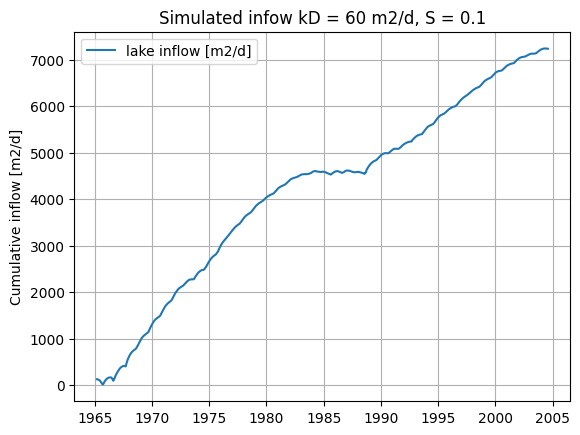

In [32]:
# Same data as before.

plt.title("Simulated infow kD = {:.0f} m2/d, S = {:.3g}".format(kD, S))
plt.ylabel('Cumulative inflow [m2/d]')
plt.grid()

tau = lake['t']
SR = np.sqrt(kD * S  / np.pi * tau)
Q = lfilter(SR, 1.0, np.diff(lake['level'])) + lake.iloc[0]['level']
plt.plot(lake.index[1:], Q, ls='-', label='lake inflow [m2/d]')
plt.legend()
plt.show()

#### 5. Compute the total inflow between 1965 and 2005
Once you can simulate this inflow using convolution, you can also integrate it over the total period of your simulation, simply by adding the daily values. So how much it this, and what is its dimension?

This is, of couse, per m of lake coast not for the entire lake which is over 500  km long.

See graph.

#### 6. Show these inflow over time in a graph below the previous one for comparison.
Is there anything special to remark with respect to the results? If you think so, say so.

See graph.

#  4. Hantush and Theis type curves

On top of this assignment notebook there is a function defined which computes the Hantush well function $W_h(u, \rho=\frac{r}{\lambda})$. You can use it or the imported function $Wt(u)$ to compute the Theis drawdown. See comment in the function definition for $W_h(u, rho)$ in the top of this notebook).

#### 1. Question

Show the type curves for the Hantush and Theis well functions. A type curve shows the well function on double log scales as a function of 1/u. The Hantush well function does this for different values of $\rho =r / \lambda$.

For the Hantush well function use the following values for `rho=r/lambda`:

In [33]:
# Set up the figure using the function Newfig defined near the top of this notebook

#ax = newfig('Hantush type curves', '1/u', 'Wh(u)', xscale='log', yscale='log',
#            ylim=(1e-3, 20), figsize=(8, 8))

# Use the following range for u
u = np.logspace(-6, 1, 71)

for rho in [3, 2, 1, 0.3, 0.2, 0.1, 0.03, 0.02, 0.01]:
    # plot the type curve here using plt.plot(...)
    # document each curve using a label and plut the value of r/L in that label.
    pass
#ax.legend(loc='lower right')

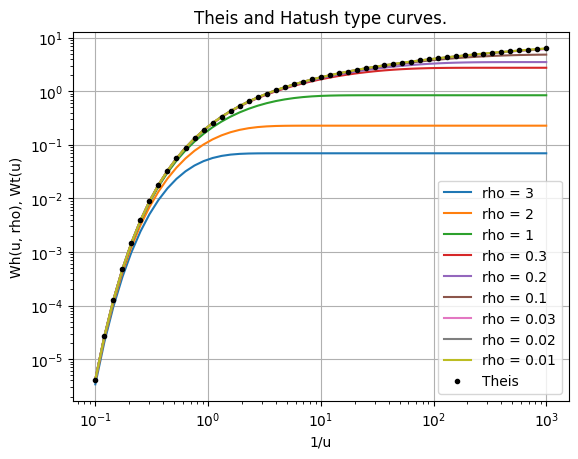

In [34]:
rhos = [3, 2, 1, 0.3, 0.2, 0.1, 0.03, 0.02, 0.01]

u = np.logspace(-3, 1, 51)
plt.title('Theis and Hatush type curves.')
plt.xlabel('1/u')
plt.ylabel('Wh(u, rho), Wt(u)')
plt.xscale('log')
plt.yscale('log')
plt.grid()
for rho in rhos:
    plt.plot(1/u, Wh(u, rho), label='rho = {}'.format(rho))

plt.plot(1/u, Wt(u), 'k.', label='Theis')
plt.legend()
plt.show()

# 5. Pumping experiment

There was a puping test in an aquifer covered by a shallow clay layer on top of which is a sand layer with a very low transmissivt. This sand layer has a water level that is only affected by rain, evaporation and leakage. Ignore the rain and precipitation.

The pumping was done in below the clay layer. The drawdown in both the top and bottom layer was measured in six piezometrs during the entire long pumping test. These drawdowns for each distance to the well are in the accompanying directory in a set of `piez###m.csv` files. Each one has the time of measurement, and the drawdown in the top and bottom layer (aquif1 and aquif2).

In the same directory is a file `Q.txt` which says what the discharge of the well was.

You can read the data in the file using pandas like so:

In [35]:
ptest_dir = os.path.join('./data', 'pump_test')
assert os.path.isdir(ptest_dir), "Can't open your pump_test directory!"

print(ptest_dir)

./data/pump_test


So the directory exists and it is printed above.
Then look wat files are in it.
I use an external command to show them (by usin the exclamaton point)

In [36]:
!ls './data/pump_test'

piez12m.csv piez20m.csv piez32m.csv piez57m.csv piez70m.csv piez88m.csv


But we can also use the os module without resorting to an extermal command, yields a list that we can use afterwards.

In [37]:
myfiles = os.listdir(ptest_dir)
print('myfiles =', myfiles)
csvfiles = [f for f in myfiles if f.endswith('.csv')]
print('csvfiles =', csvfiles)

myfiles = ['piez57m.csv', 'piez20m.csv', 'piez70m.csv', 'piez88m.csv', 'piez32m.csv', 'piez12m.csv']
csvfiles = ['piez57m.csv', 'piez20m.csv', 'piez70m.csv', 'piez88m.csv', 'piez32m.csv', 'piez12m.csv']


The Q.txt file has the extraction by the well in [m3/d].

Each csv files has the distance to the well in its name.

We can read them in by pd.read_csv, which yields a pd.DataFrame (a table object with a large number of function (methods) in it.

It's convienietn to immediately put the data in a dictionary where the key is the distance from the well.

In [38]:
piezoms = {}
for fname in csvfiles:
    key = int(fname[4:-5])    
    piezoms[key] = pd.read_csv(os.path.join(ptest_dir, fname))
piezoms = dict(sorted(piezoms.items()))
piezoms.keys()

dict_keys([12, 20, 32, 57, 70, 88])

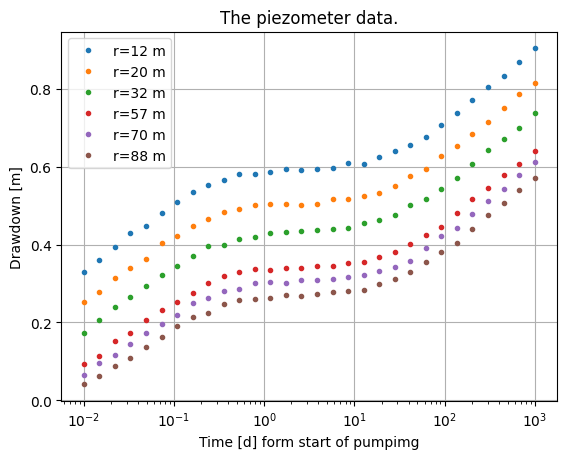

In [39]:
plt.grid()
plt.xscale('log')
plt.title("The piezometer data.")
plt.xlabel('Time [d] form start of pumpimg')
plt.ylabel('Drawdown [m]')

for key in piezoms:
    plt.plot(piezoms[key]['time_d'].values, piezoms[key]['aquif2'].values, '.', label='r={} m'.format(key))
plt.legend()
plt.show()

You see the beginnig the measurments follow straight lines as is expected with drawdowns according to Theis. Then they become horizontal, i.e. steady state, according to Hantush. And finally the turn upwards again like (antother Theis).

## Quesions:

#### 1.  Interprete the first part of the measurement lines to determine the transmissivity and the storage coefficient.

With the obtaind kD and S, compute the darwdown according to Theis and plot them with thin lines. Use linewidth (lw=0.5 or so) in the plt.plot command.

$$ s = \frac{Q}{4 \pi kD} \ln(\frac{2.25 kD t}{r^2 S})$$

Drawdown Per logcycle, $s_{LC}$:

$$ s_{LC} = s_{10t} - s_{t} = \frac{Q}{4 \pi kD} \ln(10)$$

Hence,

$$kD = \frac{Q \ln(10)}{4 \pi s_{LC}}$$


In [40]:
# The drawdown per log-cycle of the straight line of the curves if for every piezometer the same (which is according to Theis)
Q = 746 # m3/d
sLC = 0.17 # m (read from the graph, dd per log cycle)
kD = Q * np.log(10) / (4 *  np.pi * sLC)
print("kD = {:.0f} m2/d.".format(kD))

kD = 804 m2/d.


The storage coefficient comes from finding the intersection of the straight part of the drawdow on half-log scale with zero drawdown. In that case the argument of the logarithm of the simplified Theis formula is 1.

$$\frac{2.25 kD t_{s=0}}{r^2 S} = 1$$

$$s = \frac{2.25 kD t_{s=0}}{r^2}$$

Fro the piezometer farthest away (88 m) we can just read the time of zero drawdown from the graph. It is $t_{s=0, r=88} = 5 \times 10^{-3}$ d.

In [41]:
t0_88 = 5e-3 # d (read from graph) 
r = 88.0 # m
S = 2.25 * kD * t0_88 / r ** 2
print('S = {:.4f} [-]'.format(S))

S = 0.0012 [-]


#### 2.  Try also to match the curve including the horizontal part using the Hantsh well function

This should give the `lambda` and from it the and the resistance `c`.

You can now add the Hantush drawdown to the plot. They should coincide with the Theis ones in the fist part.

This may be done by estimating a value for rho

This can be done for any of the curves. We just use the one for the piezometer at r=88 m

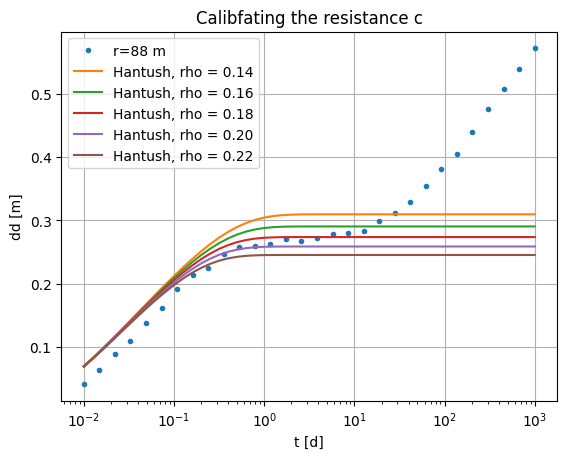

In [42]:
r = 88
t = np.logspace(-2, 3, 51) # times
u = r ** 2 * S / (4 * kD * t)

rhos = np.arange(0.14, 0.24, 0.02)
plt.title("Calibfating the resistance c")
plt.xlabel('t [d]')
plt.ylabel('dd [m]')
plt.xscale('log')
plt.grid()

r = 88
pz = piezoms[r]
plt.plot(pz['time_d'].values, pz['aquif2'].values, '.', label='r={} m'.format(r))
for rho in rhos:
    s = Q / (4 * np.pi * kD) * Wh(u, rho)
    plt.plot(t, s, label='Hantush, rho = {:.2f}'.format(rho))

plt.legend()
plt.show()


So about 0.2 is a good value for $rho = r / \lambda$.

We see also that the straigt line could be a little bit less steep and the zero intersection smaller. With this routine we can just adapt the value of kD and S to get a better match with the data.

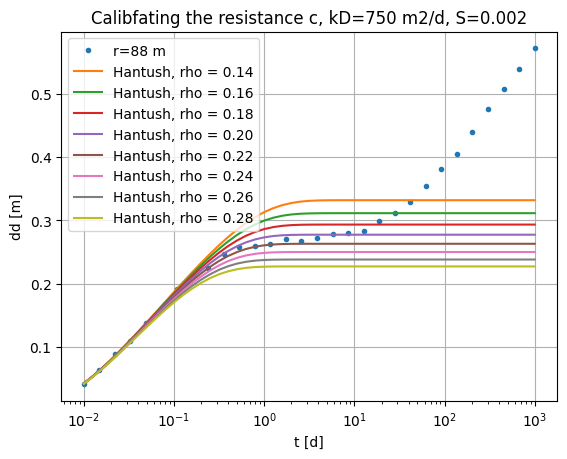

In [43]:
kD = 750
S = 0.0020
r = 88
t = np.logspace(-2, 3, 51) # times
u = r ** 2 * S / (4 * kD * t)

rhos = np.arange(0.14, 0.28, 0.02)
plt.title("Calibfating the resistance c, kD={:.0f} m2/d, S={:.3g}".format(kD, S))
plt.xlabel('t [d]')
plt.ylabel('dd [m]')
plt.xscale('log')
plt.grid()

r = 88
pz = piezoms[r]
plt.plot(pz['time_d'].values, pz['aquif2'].values, '.', label='r={} m'.format(r))
for rho in rhos:
    s = Q / (4 * np.pi * kD) * Wh(u, rho)
    plt.plot(t, s, label='Hantush, rho = {:.2f}'.format(rho))

plt.legend()
plt.show()


This worked well for the parameters in the title and for $\rho=\frac{r}{\lambda} = 0.22$.

Hence,

$$ \frac{r}{\lambda} = 0.22 = \frac{88}{\lambda} \,\,\, \rightarrow \,\,\, \lambda = 88 / 0.22 = 400$$

$$ \lambda^2 = kD c \,\,\, c = \frac{\lambda^2}{kD} = \frac{400^2}{750} \approx 210 $$

We can now show the Hantush solution together with all other piezometer

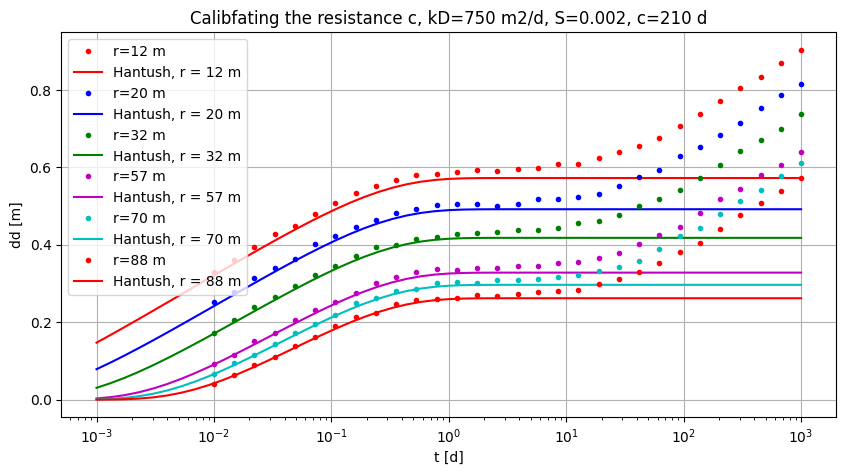

In [44]:
kD = 750 # m2/d
S = 0.0020 # [-]
c = 210. # d
L = np.sqrt(kD * c)
t = np.logspace(-3, 3, 51) # times

plt.title("Calibfating the resistance c, kD={:.0f} m2/d, S={:.3g}, c={:.3g} d".format(kD, S, c))
plt.xlabel('t [d]')
plt.ylabel('dd [m]')
plt.xscale('log')
plt.grid()

clrs = cycle('rbgmc')
for r in piezoms:
    clr = next(clrs)
    pz = piezoms[r]
    plt.plot(pz['time_d'].values, pz['aquif2'].values, '.', color=clr, label='r={} m'.format(r))

    u = r ** 2 * S  / (4 * kD * t)
    rho = r / L
    s = Q / (4 * np.pi * kD) * Wh(u, rho)
    plt.plot(t, s, color=clr, label='Hantush, r = {:.0f} m'.format(r))

plt.gcf().set_size_inches(10, 5)
plt.legend()
plt.show()


The graphs all nicely fit the data.

#### 3. Try to match the the straigt part of the lines at the end according to Theis (kD and c)

What is the difference beween the data obtained from the second straight part and the fist straight part of the lines?

With the obtained values of kD and S, add the Theis drawdown curve to the figure..

In [45]:
2.25 * 750 * 1e-3 / (32 ** 2)

0.00164794921875

The large (straight) part of the curves are parallel to the first straight parts and, therefore, the transmissivit, kD, is the same. (Same drawdown per log cycle).

However, the intersection with zero is different.

I extended the graph one logcycle on the left so that we can easily get the intersection of the straight parts with the zero drawdown.

For the curve r=32 m it intersection with zero drawdown for the first straight part is about $t_0 = 10\times10{-3}$ and for the second straight part it is about $s_0=10\times{-1}$, i.e 100 times as mucht.

This is then also true for the storage coefficient, for which we have from the first part

$$ S_1 = \frac{2.25 kD t_{s=0}}{r^2} = \frac{2.25 \times 750 \times 10^{-3}}{32^2} \approx 0.0016 $$

ad for the second straight part it is 100 times more or

$$ S_2 = \frac{2.25 kD t_{s=0}}{r^2} = \frac{2.25 \times 750 \times 10^{-1}}{32^2} \approx 0.16 $$






The intersection for first straight line portion of the same curve was a bit less than $3\times10^{-3}$



#### 4. Explain what happens in this case, what causes this curves straight-up - horizontal - straight-up?

The beahvior is explained as due to the delayed drawdown in the layer above the pumped aquifer. Contrary to the elastic and therefore, fast drawdown in the pumped aquifer the drawdown in the water table aquifer above is slow, it has a 100 times larger storage coefficient. The drawdown in the top layer is caused by downward leakage, which is slow due to the resistant aquitard. But because drawdown in the pumped aquifer slows down over time (same drawdown per logcycle!), the ongoing drawdown in the pumped aquifer will become so slow that that of the shallow aquifer starts taking up with it and later the two decline samultaeously at the same rate. When that happens, the two behave exactly according to Theis but with the Specificl yield as storage coefficient instead of the elastic storage coefficient. And so, the parallel straight portions of the same drawdown curve are shifted on the logratihmic time axis by exctly their ratio. Hence, when the the specific yield of the top layer is 100 times larger than the storage coefficient of the pumped aquifer, then the later straight portion of the drawdown curve is exactly shifted 2 logcycles (facto of 100) to the right of the first one.

#### 5. Add the drawdowns of the top layer to the curves

Finally add the measured drawdowns of the first layer to the plot.

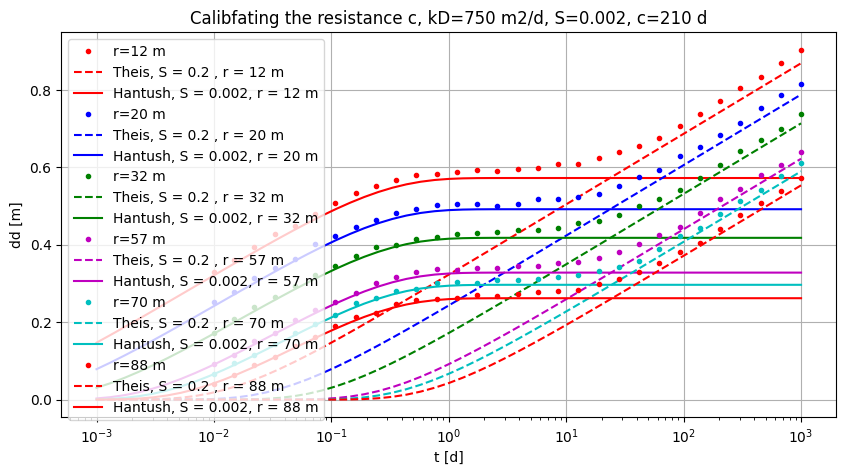

In [46]:
kD = 750 # m2/d
S1, S2 = 0.20, 0.002 # [-]
c = 210. # d
L = np.sqrt(kD * c)
t = np.logspace(-3, 3, 51) # times

plt.title("Calibfating the resistance c, kD={:.0f} m2/d, S={:.3g}, c={:.3g} d".format(kD, S, c))
plt.xlabel('t [d]')
plt.ylabel('dd [m]')
plt.xscale('log')
plt.grid()

clrs = cycle('rbgmc')
for r in piezoms:
    clr = next(clrs)    
    pz = piezoms[r]
    plt.plot(pz['time_d'].values, pz['aquif2'].values, '.', color=clr, label='r={} m'.format(r))

    u1 = r ** 2 * S1  / (4 * kD * t)
    u2 = r ** 2 * S2  / (4 * kD * t)
    
    rho = r / L
    s = Q / (4 * np.pi * kD) * Wh(u1, 0) # same as Theis
    plt.plot(t, s, color=clr, ls='--', label='Theis, S = {:.3g} , r = {:.0f} m'.format(S1, r))
    s = Q / (4 * np.pi * kD) * Wh(u2, rho)
    plt.plot(t, s, color=clr, label='Hantush, S = {:.3g}, r = {:.0f} m'.format(S2, r))


plt.gcf().set_size_inches(10, 5)
plt.legend()
plt.show()


#### 5. Try to explain why they behave like they do.

See explanation in preview section.